# Tech Tutorial 3: Audio-as-Data

In this tutorial, we will be covering some of the basics of audio analysis for social science research.

There will be two main topics covered in this tutorial:
1. Computational Phonology
2. Deep Learning

# I. Data prep

First, we're going to prepare our data and import some packages.

In [ ]:
!pip install librosa
!pip install pydub
!pip install transformers
!pip install webrtcvad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from IPython.display import Audio, display

Make sure you have the `tech-tutorial-audio-as-data` folder properly placed in your Google Drive.

In this tutorial, we are going to be using audio from The Alex Jones Show Dataset. To play around with the basics of audio analysis, we're going to start by looking at one specific radio episode.

Each episode is 4 hours long. To reduce runtime, we're going to subset down to only the first 10 minutes of the show.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

audio_path = '/content/drive/MyDrive/tech-tutorial-audio-as-data/mp3s/20221106_Sun_Alex.mp3'
audio_data, sr = librosa.load(audio_path)

# Convert audio data to an AudioSegment object
audio_segment = AudioSegment.from_file(audio_path)

# Set the desired duration (in milliseconds)
desired_duration = 10 * 60 * 1000  # 10 minutes

# Trim the audio segment to the desired duration
trimmed_audio_segment = audio_segment[:desired_duration]

# Export the trimmed audio segment as a new audio file (optional)
trimmed_audio_path = '/content/drive/MyDrive/tech-tutorial-audio-as-data/trimmed_mp3s/trimmed_audio.mp3'
trimmed_audio_segment.export(trimmed_audio_path, format='mp3')

# Load the trimmed audio file with librosa
trimmed_audio_data, sr_trimmed = librosa.load(trimmed_audio_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


II. Introduction to Computational Phonology with `librosa`

`librosa` is a Python library for audio and signal processing. It provides a wide variety of functionality for reading in audio data and extracting audio features.

First, we will go over some of the features that can be extracted. Then, we will cover how these features can be used as a part of statistical inference.

## A. Representations of Audio Data

One of the most typical ways that audio data is visualized, for example in audio editing software, is via a waveform. The waveform of an audio signal is a graphical representation that shows how the amplitude of the signal varies over time. It provides a visual depiction of the changes in air pressure or voltage that correspond to the sound waves captured by a microphone or other recording device.

In a waveform plot, the horizontal axis represents time, typically measured in seconds, while the vertical axis represents the amplitude or intensity of the audio signal. The waveform shows the pattern of oscillations or vibrations of the sound wave as it propagates through time.

The shape of the waveform provides valuable information about the characteristics of the audio signal. For example, the overall shape can reveal the presence of specific audio features such as speech, music, or noise. The amplitude of the waveform indicates the loudness or intensity of the sound at each point in time, with higher peaks indicating louder sections and lower peaks indicating quieter sections.

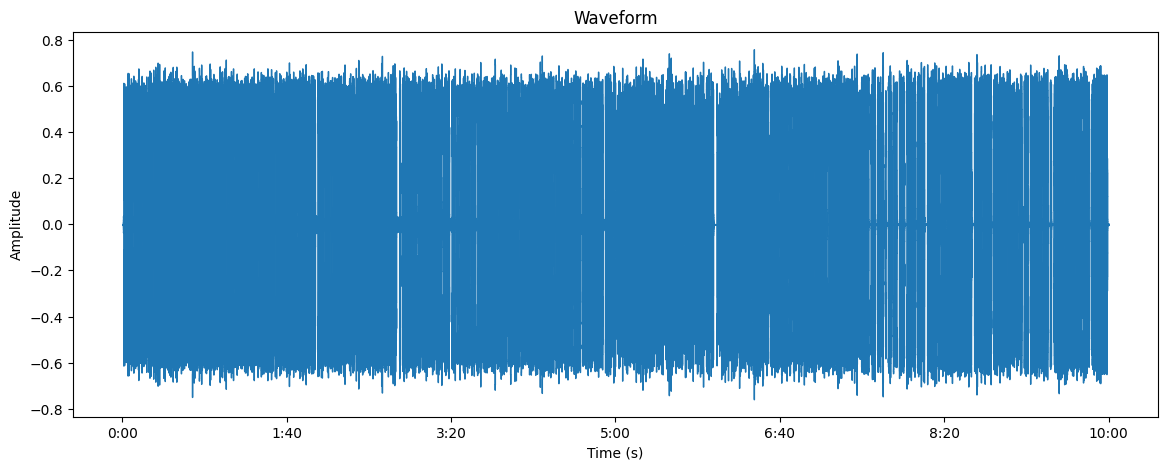

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(trimmed_audio_data, sr=sr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

Spectrograms are a visual representation of the frequencies present in an audio signal over time. It is computed by applying the Short-Time Fourier Transform (STFT) to the audio data, which involves dividing the signal into short overlapping segments and calculating the Fourier Transform for each segment. The resulting spectrogram represents the amplitude of different frequencies as a function of time. In the code, the librosa.stft function is used to compute the spectrogram of the trimmed audio data.

To enhance the interpretation of the spectrogram, we convert the amplitude values to the decibel scale using the librosa.amplitude_to_db function. This conversion allows us to better visualize the dynamic range of the spectrogram, with higher values indicating higher amplitudes and lower values indicating lower amplitudes. The resulting spectrogram_db provides a more perceptually meaningful representation of the audio signal's frequency content.

In [ ]:
# Compute spectrogram
spectrogram = librosa.stft(trimmed_audio_data)
spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))

The spectrogram is represented as a 2D plot where the x-axis represents time and the y-axis represents frequency. Each point in the plot corresponds to the magnitude of a particular frequency component at a specific time. The color of each point represents the magnitude of the frequency component, with different colors indicating different amplitudes.

To interpret the spectrogram plot:

- Time axis: The x-axis represents time in seconds. It shows the duration of the audio signal, with the leftmost point corresponding to the start of the audio and the rightmost point corresponding to the end of the audio.

- Frequency axis: The y-axis represents frequency in Hertz (Hz). It shows the range of frequencies present in the audio signal. The lowest frequencies are at the bottom, and the highest frequencies are at the top.

- Color intensity: The color of each point in the plot represents the magnitude or amplitude of the corresponding frequency component. Brighter or more intense colors indicate higher amplitudes, while darker or less intense colors indicate lower amplitudes.

- Colorbar: The colorbar on the right side of the plot provides a reference scale for interpreting the color intensity. It indicates the corresponding decibel (dB) values of the color intensities in the plot.

The logarithmic scaling of the y-axis (y_axis='log') is commonly used to better represent the wide frequency range in audio signals. It compresses the higher frequencies, allowing us to see details in both low and high frequencies more clearly.

By visualizing the spectrogram, we can gain insights into the frequency content and how it changes over time in the audio signal. We can identify patterns, distinguish between different sounds or frequencies, and analyze the temporal variations in the signal. The spectrogram plot is widely used in fields like speech processing, music analysis, and sound recognition to understand the spectral characteristics of audio signals.

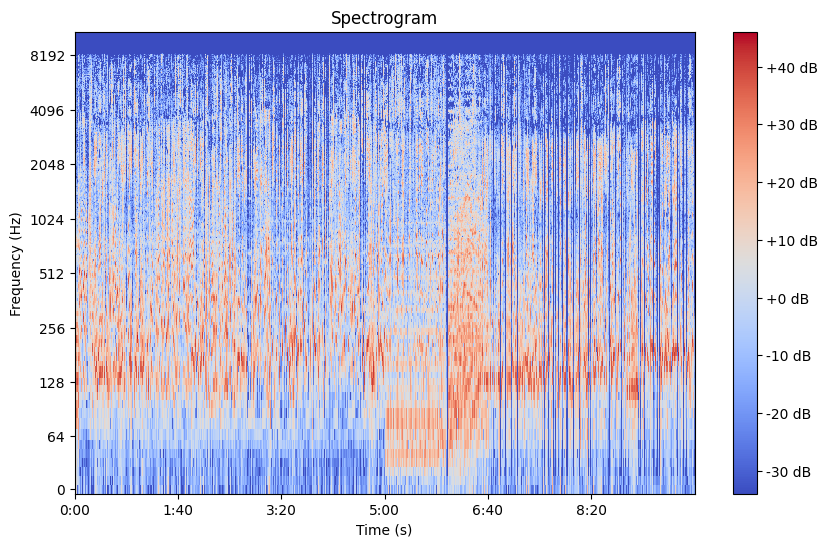

In [ ]:
# Visualize the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

Similarly, we can create a mel-spectrogram, which is a variant of the spectrogram that uses the Mel scale to represent the frequency axis. The Mel scale is a perceptual scale that emphasizes differences in lower frequencies and de-emphasizes differences in higher frequencies, more closely aligning with how humans perceive sound.

Similar to the spectrogram, we convert the mel-spectrogram amplitude values to the decibel scale using librosa.amplitude_to_db, with the additional parameter ref=np.max. This parameter sets the reference value for the conversion to the maximum amplitude in the mel-spectrogram. The resulting mel_spectrogram_db provides a visually enhanced representation of the frequency content in the mel-spectrogram, making it easier to analyze and interpret.

By computing the spectrogram and mel-spectrogram, we can gain insights into the frequency content and temporal variations of the audio signal. These representations are widely used in audio analysis tasks such as speech recognition, music genre classification, and sound event detection. They provide valuable information about the distribution of frequencies over time and can help identify specific features and patterns in the audio data.

In [ ]:
# Compute mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=trimmed_audio_data, sr=sr)
mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

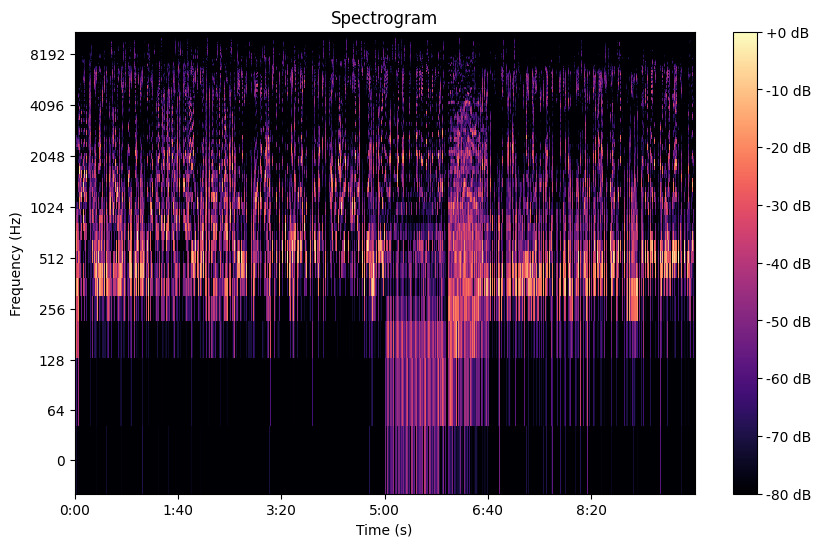

In [ ]:
# Visualize the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## B. Audio Feature Extraction

There are other, more specific features that we may be interested in extracting from audio. We will go over a few here

Chroma is most often used in music analysis and is basically the musical note that a tone is closest to. When we listen to music, we can perceive different musical notes or pitches that make up the melody or harmony of a song. The chroma feature aims to capture and represent these pitch characteristics in a structured way.

Think of chroma as a way to describe the "color" of music. Just as different colors create distinct visual experiences, different pitches create unique musical experiences. The chroma feature takes these pitches and organizes them into a 12-element vector, representing the 12 different pitch classes in an octave (C, C#, D, D#, E, F, F#, G, G#, A, A#, B).

By analyzing the chroma features of a piece of music, we can gain insights into the musical patterns and tonal characteristics present. This information can be used to understand the harmonic structure, chord progressions, and melodic content of a song. For example, it can help us identify the dominant musical key, recognize chord changes, or even distinguish between different genres of music based on their unique pitch characteristics.

Often, things like emotion or speaker detection are related to the chroma of the speaker.

In [ ]:
chroma = librosa.feature.chroma_stft(y=trimmed_audio_data, sr=sr)

The plot generated by the provided code displays the chroma feature of an audio signal in the form of a spectrogram-like visualization. Here's an overview of how to interpret this plot:

- X-Axis: The x-axis represents time, indicating the duration of the audio signal. Each point on the x-axis corresponds to a specific time point in the audio.
- Y-Axis: The y-axis represents the pitch class, which refers to the different musical notes. It ranges from C to B, representing the 12 notes in an octave.
- Color Intensity: The color intensity at each time-pitch class combination represents the strength or presence of that particular pitch class at that specific time. Darker colors indicate higher intensity, while lighter colors indicate lower intensity.

Interpretation:

- Time-Varying Pitch: The plot shows how the pitch content of the audio signal changes over time. Bright or dark regions in the plot indicate the presence of specific pitch classes at different time points. This information can be used to identify melodic patterns or pitch variations in the audio.
- Musical Tonality: The plot can also reveal the tonal characteristics of the audio signal. The distribution and intensity of different pitch classes can give insights into the musical tonality of the recorded content. Patterns or clusters of pitch classes can indicate the presence of specific musical keys or tonal centers.
- Harmonic Analysis: Chroma features are particularly useful for analyzing the harmonic content of audio signals. The plot allows the visualization of harmonic relationships between different pitch classes at different time points. This information can be used to study chord progressions, harmonic changes, or even identify specific musical structures.

The color bar on the side of the plot provides a reference scale to understand the intensity values corresponding to the colors used in the plot.

Overall, this plot provides a visual representation of the chroma feature, which captures the distribution of pitch classes over time. It enables the analysis of tonal and harmonic characteristics in the audio signal and can be used for tasks such as music analysis, genre classification, or chord recognition.

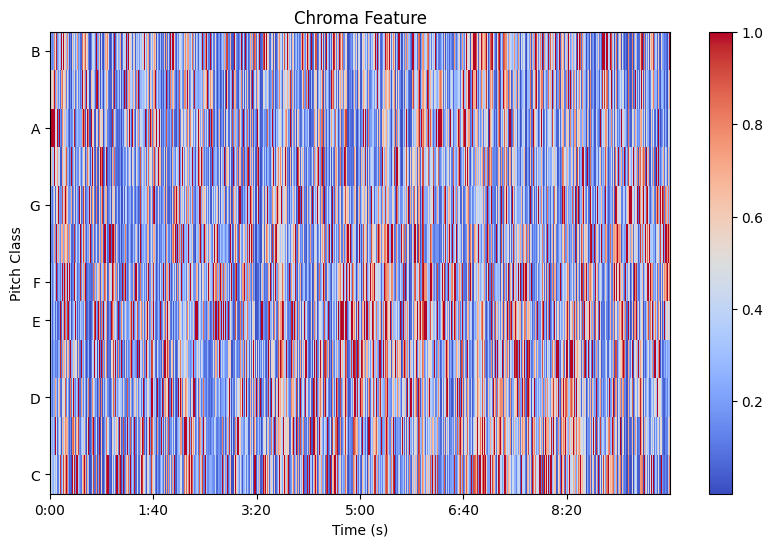

In [ ]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chroma Feature')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.show()

Tempo refers to the perceived speed or pace of a piece of music, typically measured in beats per minute (BPM). It represents the underlying rhythmic structure of the music and is often associated with the tempo at which people would naturally move or dance to the music. Tempo can also represent how quickly or slowly individuals are talking.

The librosa.beat.beat_track() function utilizes a beat tracking algorithm to estimate the tempo of the audio signal. It takes as input the trimmed audio data (trimmed_audio_data) and the sample rate (sr) at which the audio was recorded.

In this code, I am breaking the audio up into 10-second chunks and calculating the BPM per chunk.

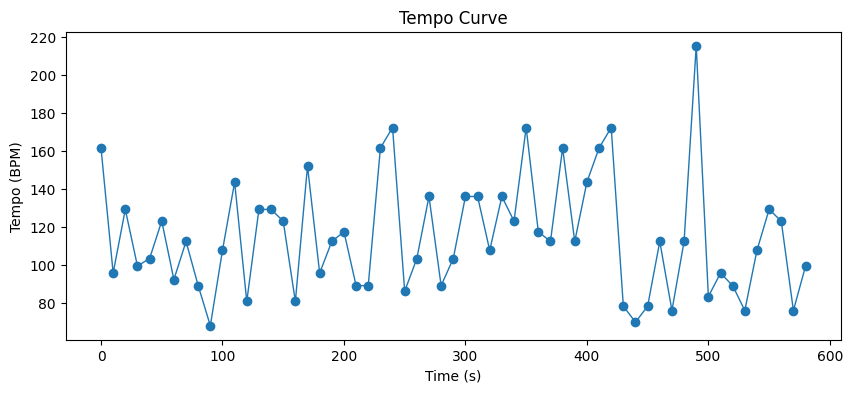

In [ ]:
# Define the boundaries of the chunks (in seconds)
chunk_duration = 10
total_duration = 600  # 10 minutes

chunk_boundaries = np.arange(0, total_duration, chunk_duration)

# Initialize an empty list to store the tempos for each chunk
chunk_tempos = []

# Process each chunk
for i in range(len(chunk_boundaries) - 1):
    start_time = chunk_boundaries[i]
    end_time = chunk_boundaries[i + 1]

    # Extract the audio data for the current chunk
    chunk_audio = trimmed_audio_data[int(start_time * sr):int(end_time * sr)]

    # Calculate the tempo for the current chunk
    tempo, _ = librosa.beat.beat_track(y=chunk_audio, sr=sr, start_bpm=120)

    # Store the tempo in the list
    chunk_tempos.append(tempo)

# Plot the tempo curve
plt.figure(figsize=(10, 4))
plt.plot(chunk_boundaries[:-1], chunk_tempos, marker='o', linestyle='-', linewidth=1)
plt.title('Tempo Curve')
plt.xlabel('Time (s)')
plt.ylabel('Tempo (BPM)')
plt.show()


Pitch refers to how high or low a sound is perceived by our ears. It is closely related to the frequency of the sound waves. When you hear a musical note or a person's voice, the pitch is what allows you to differentiate between high and low tones.

Think of a musical instrument like a guitar or piano. When you pluck a guitar string or press a piano key, the resulting sound has a specific pitch. Higher-pitched sounds have faster sound wave vibrations, while lower-pitched sounds have slower vibrations.

In the context of the code you provided, the pitch is extracted from the audio data. This allows you to analyze the variations in pitch over time. By plotting the pitch values, you can visually understand how the tone or perceived highness/lowness of the sound changes throughout the audio.

So, in simple terms, pitch refers to the highness or lowness of a sound, and analyzing the pitch can help us understand how the tone of a sound changes over time.

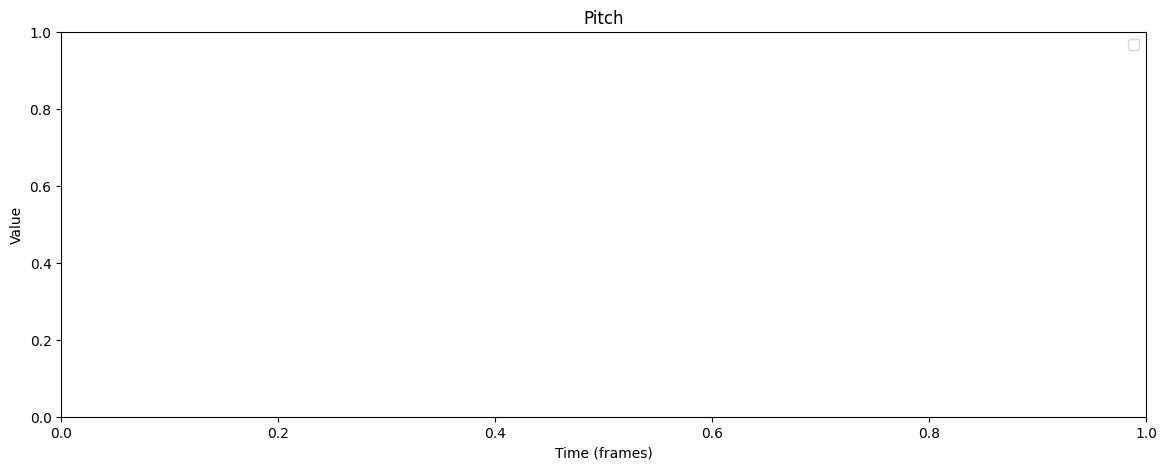

In [ ]:
# Extract pitch from audio data
pitch, _ = librosa.piptrack(y=trimmed_audio_data, sr=sr)

# Plot pitch
pitch_mean = np.mean(pitch, axis=0)

# Plot tone analysis
plt.figure(figsize=(14, 5))
plt.xlabel('Time (frames)')
plt.ylabel('Value')
plt.title('Pitch')
plt.legend()
plt.show()

Intensity refers to the loudness or strength of a sound. It is a measure of the energy or power present in the sound waves. When a sound is louder or more powerful, it has a higher intensity.

Imagine someone speaking softly versus shouting loudly. The shouted words have a higher intensity because they create stronger sound waves that reach your ears with more force. Intensity is often associated with the perceived volume of a sound.

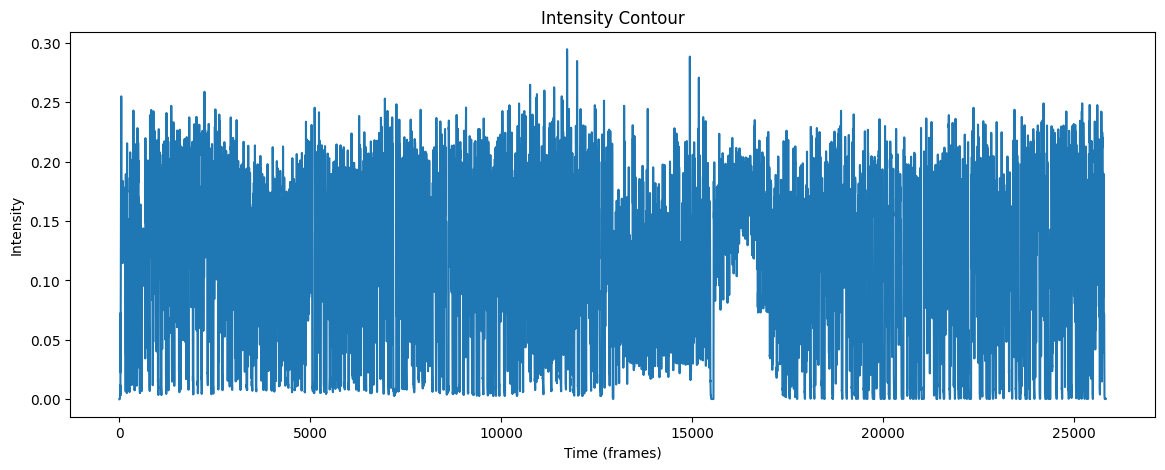

In [ ]:
# Extract intensity from audio data
intensity = librosa.feature.rms(y=trimmed_audio_data)

# Plot intensity contour
plt.figure(figsize=(14, 5))
plt.plot(intensity[0])
plt.xlabel('Time (frames)')
plt.ylabel('Intensity')
plt.title('Intensity Contour')
plt.show()


MFCCs (Mel Frequency Cepstral Coefficients) are a set of features or measurements that represent the characteristics of the sound or speech.

When we speak or produce sound, the characteristics of the sound wave can be analyzed and represented by these coefficients. MFCCs capture information related to the frequency content of the sound over time. They are commonly used in audio and speech processing tasks to analyze and recognize different sounds or phonemes.

There are 13 MFCC coefficients, each representing a different feature of audio.

- MFCC 1: Represents the overall energy or power of the audio signal.

- MFCC 2-13: These coefficients capture information about the shape of the spectral envelope, emphasizing different frequency bands. They are often referred to as "mel-frequency cepstral coefficients" because they are calculated based on the mel-frequency scale, which approximates the human auditory system's perception of pitch.
  - MFCC 2: Related to the spectral shape and represents lower frequency components.
  - MFCC 3: Captures information about transitions between adjacent spectral bands.
  - MFCC 4-7: Represent various aspects of spectral shape and envelope.
  - MFCC 8-13: Represent higher frequency components and provide details about the fine structure of the audio signal.

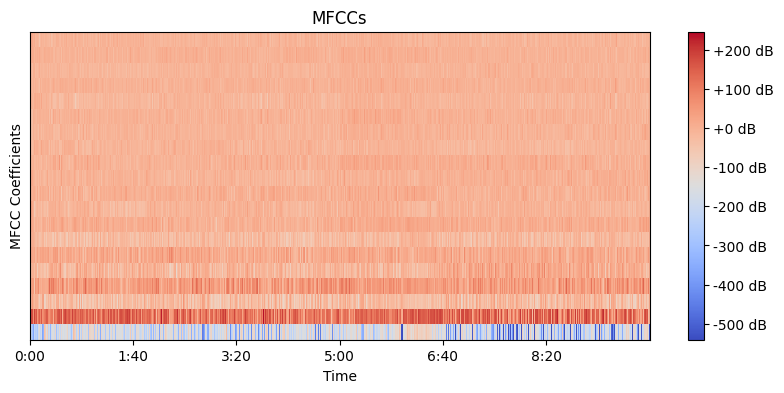

In [ ]:
mfccs = librosa.feature.mfcc(y=trimmed_audio_data, sr=sr)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()


Spectral contrast is a feature that measures the difference in magnitudes between peaks and valleys in the frequency spectrum of an audio signal. It characterizes the emphasis or distinction between different frequency regions in the audio.

The plot shows the spectral contrast of an audio signal over time. The y-axis represents different spectral contrast bands, which correspond to specific frequency regions, and the x-axis represents time. The color intensity in the plot indicates the magnitude of the spectral contrast in each frequency band at different time points.

The interpretation of the plot involves understanding how the spectral contrast values change over time and across different frequency regions. Higher values of spectral contrast indicate a greater difference between the magnitudes of peaks and valleys in the corresponding frequency bands, suggesting a more pronounced distinction between frequency components in those regions.

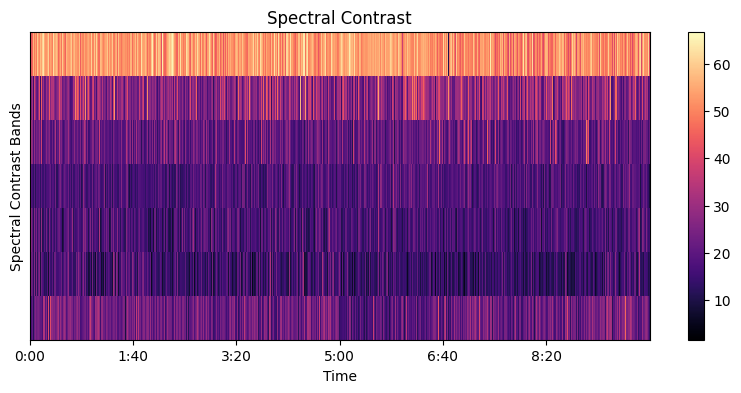

In [ ]:
spectral_contrast = librosa.feature.spectral_contrast(y=trimmed_audio_data, sr=sr)

# Plot Spectral Contrast
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectral_contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')
plt.xlabel('Time')
plt.ylabel('Spectral Contrast Bands')
plt.show()

The zero-crossing rate of an audio signal and provides a way to understand the frequency of sign changes in the waveform. In simpler terms, it tells us how frequently the audio signal changes from positive to negative or vice versa.

The plot shows the audio waveform and the zero-crossing rate.

The audio waveform, represented by the blue line, displays the amplitude or strength of the audio signal over time. It provides a visual representation of the audio's loudness or intensity. The x-axis represents time, while the y-axis represents the amplitude of the audio signal.

The red line represents the zero-crossing rate, which indicates the rate at which the audio signal crosses the zero axis. It represents the number of times the audio waveform changes its sign (from positive to negative or vice versa) within a given time interval. A higher zero-crossing rate suggests more rapid changes or transitions in the audio signal, while a lower rate indicates smoother or less dynamic sections.

By plotting the zero-crossing rate alongside the audio waveform, we can observe the relationship between the waveform's shape and the zero-crossing rate. Regions with frequent sign changes will correspond to peaks or spikes in the zero-crossing rate. On the other hand, smoother sections with fewer transitions will result in lower values on the zero-crossing rate plot.

This plot helps in understanding the dynamic characteristics of the audio signal. It can provide insights into the rhythm, timbre, and overall texture of the audio. In speech analysis, it can help identify boundaries between different phonetic sounds, while in music analysis, it can indicate rhythmic patterns or percussive elements.

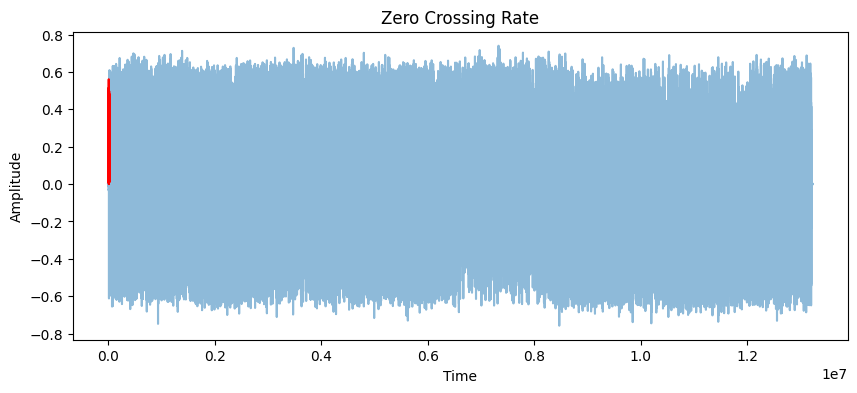

In [ ]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=trimmed_audio_data)

plt.figure(figsize=(10, 4))
plt.plot(trimmed_audio_data, alpha=0.5)
plt.plot(zero_crossing_rate[0], color='r')
plt.title('Zero Crossing Rate')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## C. Intra-audio file analysis

These features can be used to understand fluctuations within an audio file. For example, in the code below, we are extracting various audio features over time windows (hop_length).

I am creating a dummy outcome variable Y that may represent some value that is fluctuating over the course of the audio, for example, the number of likes an audio stream is receiving.

Then, we can put all of the features into a regression predicting this outcome.

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels.api as sm

window_size = 0.1  # Adjust this value as per your requirement
hop_length = int(sr * window_size)

# Extract audio features with temporal alignment
spectrogram = np.abs(librosa.stft(trimmed_audio_data, hop_length=hop_length))
chroma = librosa.feature.chroma_stft(y=trimmed_audio_data, sr=sr, hop_length=hop_length)
mfcc = librosa.feature.mfcc(y=trimmed_audio_data, sr=sr, hop_length=hop_length)
zero_crossing_rate = librosa.feature.zero_crossing_rate(trimmed_audio_data, hop_length=hop_length)
spectral_rolloff = librosa.feature.spectral_rolloff(y=trimmed_audio_data, sr=sr, hop_length=hop_length)
intensity = librosa.feature.rms(y=trimmed_audio_data, frame_length=hop_length, hop_length=hop_length)

# Take the minimum length among all feature matrices
min_length = min(spectrogram.shape[1], chroma.shape[1], mfcc.shape[1], zero_crossing_rate.shape[1],
                 spectral_rolloff.shape[1], intensity.shape[1])

# Trim the feature matrices to the minimum length
spectrogram = spectrogram[:, :min_length]
chroma = chroma[:, :min_length]
mfcc = mfcc[:, :min_length]
zero_crossing_rate = zero_crossing_rate[:, :min_length]
spectral_rolloff = spectral_rolloff[:, :min_length]
intensity = intensity[:, :min_length]

# Create a DataFrame for the features
df = pd.DataFrame({'Spectrogram': spectrogram[0],
                   'Chroma 1': chroma[0],
                   'Chroma 2': chroma[1],
                   'Chroma 3': chroma[2],
                   'Chroma 4': chroma[3],
                   'Chroma 5': chroma[4],
                   'Chroma 6': chroma[5],
                   'Chroma 7': chroma[6],
                   'Chroma 8': chroma[7],
                   'Chroma 9': chroma[8],
                   'Chroma 10': chroma[9],
                   'Chroma 11': chroma[10],
                   'Chroma 12': chroma[11],
                   'MFCC 1': mfcc[0],
                   'MFCC 2': mfcc[1],
                   'MFCC 3': mfcc[2],
                   'MFCC 4': mfcc[3],
                   'MFCC 5': mfcc[4],
                   'MFCC 6': mfcc[5],
                   'MFCC 7': mfcc[6],
                   'MFCC 8': mfcc[7],
                   'MFCC 9': mfcc[8],
                   'MFCC 10': mfcc[9],
                   'MFCC 11': mfcc[10],
                   'MFCC 12': mfcc[11],
                   'Zero Crossing Rate': zero_crossing_rate[0],
                   'Spectral Rolloff': spectral_rolloff[0],
                   'Intensity': intensity[0]})

# Create dummy target variable
y = np.random.randint(low=0, high=1000, size=df.shape[0]) * np.random.uniform(low=0.5, high=2.0, size=df.shape[0])

# Perform linear regression
X = sm.add_constant(df)  # Add constant term for intercept
regression_model = sm.OLS(y, X)
regression_results = regression_model.fit()

# Print regression summary table
print(regression_results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8362
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.712
Time:                        17:48:13   Log-Likelihood:                -45081.
No. Observations:                6000   AIC:                         9.022e+04
Df Residuals:                    5971   BIC:                         9.041e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1155.6863    371

## D. Inter-Audio file analysis

We can also summarize these features down into single numbers that represent each episode. For example, in this analysis, I am seeing if The Alex Jones Show's audio features are different before or after the show was deplatformed.

In [ ]:
import glob
import librosa
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Define the folder path and file name pattern
folder_path = '/content/drive/MyDrive/tech-tutorial-audio-as-data/mp3s'
file_pattern = '/content/drive/MyDrive/tech-tutorial-audio-as-data/mp3s/*.mp3'

# Retrieve the .mp3 file paths using glob
mp3_files = glob.glob(file_pattern)

# Define the desired duration (in seconds) for trimming
trim_duration = 600  # 10 minutes

# Define the outcome variable labels
date_threshold = pd.Timestamp('2018-08-06')
outcome_labels = ['Before deplatform', 'After deplatform']

# Initialize lists to store the mean feature values and outcome variables
feature_means = []
y_list = []

# Process each .mp3 file
for file_path in mp3_files:
    # Load the audio file
    audio_data, sr = librosa.load(file_path)

    # Trim the audio to the desired duration
    num_samples = int(trim_duration * sr)
    trimmed_audio_data = audio_data[:num_samples]

    # Extract audio features
    spectrogram = np.abs(librosa.stft(trimmed_audio_data, hop_length=hop_length))
    chroma = librosa.feature.chroma_stft(y=trimmed_audio_data, sr=sr, hop_length=hop_length, n_chroma=12)
    mfcc = librosa.feature.mfcc(y=trimmed_audio_data, sr=sr, hop_length=hop_length, n_mfcc=12)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(trimmed_audio_data, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=trimmed_audio_data, sr=sr, hop_length=hop_length)
    intensity = librosa.feature.rms(y=trimmed_audio_data, frame_length=hop_length, hop_length=hop_length)

    # Calculate the mean of each feature
    spectrogram_mean = np.mean(spectrogram)
    chroma_mean = chroma.mean(axis=1).tolist()  # Convert to list
    mfcc_mean = mfcc.mean(axis=1).tolist()  # Convert to list
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    intensity_mean = np.mean(intensity)

    # Append the mean feature values to the list
    feature_means.append([spectrogram_mean] + chroma_mean + mfcc_mean + [zero_crossing_rate_mean,
                          spectral_rolloff_mean, intensity_mean])

    # Extract the date from the file name
    file_name = file_path.split('/')[-1]
    date_str = file_name[:8]
    file_date = pd.to_datetime(date_str, format='%Y%m%d')

    # Create the outcome variable
    if file_date < date_threshold:
        outcome = 0  # Before deplatform
    else:
        outcome = 1  # After deplatform

    # Append the outcome variable to the list
    y_list.append(outcome)

In [ ]:
# Convert the mean feature values and outcome variables to arrays
X = np.array(feature_means)
y = np.array(y_list)

# Define feature names
chroma_names = [f'Chroma_{i}' for i in range(1, 13)]
mfcc_names = [f'MFCC_{i}' for i in range(1, 13)]
feature_names = ['Spectrogram'] + chroma_names + mfcc_names + ['Zero Crossing Rate', 'Spectral Rolloff', 'Intensity']

# Create a DataFrame for the features
df = pd.DataFrame(X, columns=feature_names)

# Perform linear regression
X = sm.add_constant(df)  # Add constant term for intercept
regression_model = sm.OLS(y, X)
regression_results = regression_model.fit()

# Print regression summary table
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     6.330
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           0.000167
Time:                        17:56:14   Log-Likelihood:                 26.859
No. Observations:                  45   AIC:                             4.282
Df Residuals:                      16   BIC:                             56.68
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.1057      4

# III. Deep Learning

One of the key advantages of deep learning for audio processing is its ability to learn hierarchical representations directly from raw audio data. Instead of relying on handcrafted features, deep learning models can automatically learn intricate patterns and representations by leveraging the power of neural networks.

Wav2Vec is a deep learning model developed by Facebook AI Research (FAIR) that is specifically designed for speech and audio processing tasks, such as automatic speech recognition (ASR) and speech representation learning. It is inspired by the success of models like Word2Vec and BERT in natural language processing and aims to learn meaningful representations of audio waveforms.

The key idea behind Wav2Vec is to learn powerful representations of raw audio waveforms using a self-supervised learning approach. Self-supervised learning means training a model on a large amount of unlabeled data without requiring explicit annotations. Instead, the model is trained to solve a pretext task, which is a task designed to provide useful supervision signals to the model.

In audio applications, deep learning models are typically designed to process audio waveforms directly. The raw audio data is usually represented as a time series of amplitude values. The models analyze the temporal patterns in the waveform, capturing short-term and long-term dependencies within the audio signal.

One of the most common deep learning tasks with audio data is transcription. Here, we will transcribe the first 20 seconds of our audio file.

Off-the-shelf, the model transcribes poorly. Finetuning is very important for transcription.

In [ ]:
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

# Load the pre-trained Wav2Vec model
model = Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-base-960h')
tokenizer = Wav2Vec2Tokenizer.from_pretrained('facebook/wav2vec2-base-960h')

# Define the duration in seconds
duration = 20

# Truncate the audio data to the desired duration
max_samples = int(duration * sr)
trimmed_audio_data = trimmed_audio_data[:max_samples]

# Process the audio data
inputs = tokenizer(trimmed_audio_data, return_tensors='pt', padding=True)

# Perform speech recognition
outputs = model(inputs.input_values)
predicted_ids = torch.argmax(outputs.logits, dim=-1)
transcriptions = tokenizer.batch_decode(predicted_ids)

# Print the transcriptions
print(transcriptions)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:757: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


["YE WOL'L FIGHT O EVER CAR TO CLINE THE THEY LOFT YOU HAVE E STATES ALLER MATE RICHARD CHAY ABON TABAMA AND OTTER YEL PEEL ON TA GRISH RAGING DOLT ABOUT OTE OF THE PINE L PIVES OF THES WITS POSE TELECTION SURTION THEY GOT GOOD WORKERS BUT I DON'T BIEVIN GAT TIN MENS WITH THAN ON'T AR IN THE BAY THERE DOWN A SOR IN THE SINCE AND I HATE TO SEE"]


You can also extract embeddings from your audio, just like you would for text. Then, the embeddings can be used for almost any task that you would use text embeddings, for example, for a classification task.

For example, here are the embeddings of the beginning of this episode!

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, Wav2Vec2Processor, Wav2Vec2Model

# Load the pre-trained wav2vec2 model
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

trimmed_audio_data_2 = trimmed_audio_data[:600000]

# Process the audio data
inputs = processor(trimmed_audio_data_2, return_tensors="pt", padding=True)

# Obtain the audio embeddings
with torch.no_grad():
    embeddings = model(inputs.input_values).last_hidden_state

# Access the embeddings for further analysis
print(embeddings)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


tensor([[[ 0.0973,  0.0432, -0.3401,  ..., -0.1239,  0.1465,  0.1624],
         [-0.0479,  0.1108, -0.2788,  ..., -0.2286,  0.0215,  0.1732],
         [-0.0487,  0.1115, -0.2234,  ..., -0.2147, -0.0085,  0.0667],
         ...,
         [ 0.0602, -0.1024,  0.0855,  ...,  0.4484,  0.0054, -0.2604],
         [-0.1634, -0.0376,  0.2235,  ...,  0.1995,  0.1250,  0.0801],
         [-0.0425, -0.0246,  0.0746,  ...,  0.0809, -0.0211, -0.0506]]])


Here is a full example of using audio embeddings to build a classifier to predict whether a radio show was from before or after Alex Jones's deplatforming.

First, let's get the embeddings and outcome variable.

In [ ]:
import glob
import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the folder path and file name pattern
folder_path = '/content/drive/MyDrive/tech-tutorial-audio-as-data/mp3s'
file_pattern = '/content/drive/MyDrive/tech-tutorial-audio-as-data/mp3s/*.mp3'

# Retrieve the .mp3 file paths using glob
mp3_files = glob.glob(file_pattern)

# Define the desired duration (in seconds) for trimming
trim_duration = 60 # 60 seconds

# Define the outcome variable labels
date_threshold = pd.Timestamp('2018-08-06')
outcome_labels = ['Before deplatform', 'After deplatform']

# Initialize lists to store the audio embeddings and outcome variables
embeddings = []
y_list = []

# Load the pre-trained Wav2Vec2 model and feature extractor
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Process each .mp3 file
for file_path in mp3_files:
    # Load the audio file
    audio_data, sr = librosa.load(file_path)

    # Trim the audio to the desired duration
    num_samples = int(trim_duration * sr)
    trimmed_audio_data = audio_data[:num_samples]

    # Extract audio embeddings
    audio_input = processor(trimmed_audio_data, return_tensors="pt", padding=True)
    with torch.no_grad():
        audio_embedding = model(input_values=audio_input.input_values).last_hidden_state.mean(dim=1).squeeze(0)

    # Append the audio embedding to the list
    embeddings.append(audio_embedding)

    # Extract the date from the file name
    file_name = file_path.split('/')[-1]
    date_str = file_name[:8]
    file_date = pd.to_datetime(date_str, format='%Y%m%d')

    # Create the outcome variable
    if file_date < date_threshold:
        outcome = 0  # Before deplatform
    else:
        outcome = 1  # After deplatform

    # Append the outcome variable to the list
    y_list.append(outcome)

# Convert the lists to numpy arrays
embeddings = torch.stack(embeddings).numpy()
y = np.array(y_list)


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result 

Next, let's train a NN to predict whether a show is before or after the deplatforming using the embeddings.

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=1)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
input_size = embeddings.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.001
num_epochs = 1000
batch_size = 32

# Create the neural network model
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create custom dataset class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Create dataloaders for training and testing
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the neural network
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate average train loss
    avg_train_loss = train_loss / len(train_dataloader)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = []
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.4f}")

# Print final accuracy
print("Final Accuracy:", accuracy)


Epoch [1/1000], Train Loss: 0.7015, Accuracy: 0.6667
Epoch [2/1000], Train Loss: 0.6310, Accuracy: 0.6667
Epoch [3/1000], Train Loss: 0.5982, Accuracy: 0.6667
Epoch [4/1000], Train Loss: 0.5835, Accuracy: 0.6667
Epoch [5/1000], Train Loss: 0.4687, Accuracy: 0.6667
Epoch [6/1000], Train Loss: 0.5929, Accuracy: 0.6667
Epoch [7/1000], Train Loss: 0.7415, Accuracy: 0.6667
Epoch [8/1000], Train Loss: 0.5806, Accuracy: 0.6667
Epoch [9/1000], Train Loss: 0.5831, Accuracy: 0.6667
Epoch [10/1000], Train Loss: 0.4765, Accuracy: 0.6667
Epoch [11/1000], Train Loss: 0.4804, Accuracy: 0.6667
Epoch [12/1000], Train Loss: 0.5692, Accuracy: 0.6667
Epoch [13/1000], Train Loss: 0.5652, Accuracy: 0.6667
Epoch [14/1000], Train Loss: 0.6753, Accuracy: 0.6667
Epoch [15/1000], Train Loss: 0.5454, Accuracy: 0.6667
Epoch [16/1000], Train Loss: 0.5557, Accuracy: 0.6667
Epoch [17/1000], Train Loss: 0.5493, Accuracy: 0.6667
Epoch [18/1000], Train Loss: 0.4590, Accuracy: 0.6667
Epoch [19/1000], Train Loss: 0.5466, 

Just for fun, let's compare this accuracy to a regression using the embeddings.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

# Train a logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6666666666666666


It looks like our model is just reverting to a naive classifier. Oh well, what can you expect on only 60 seconds of data?!